# Interpretability methods applied on the FFNN used to awnser RQ1

## importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200
device='cpu'

In [3]:
X_train = pd.read_csv('../datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('../datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('../datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('../datasets/Bikerental/y_test.csv',index_col=0)  
from sklearn.model_selection import train_test_split

# Specify the split ratio. For example, let's use 80% for training and 20% for validation
split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split_ratio, random_state=42)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
config = {
    'hidden_layers': 3,
    'hidden_units': [128, 128, 64],
    'dropout': False,
    'dropout_array': [0.5, 0.3225943639867505, 0.6472032609256847],
    'activation': nn.ReLU(),
    'norm': False,
    'lr':0.005,
    'batch_size':8,
    'num_epochs':400
    
}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [9]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [10]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [11]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()

## Loading model

In [14]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [15]:
#net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [17]:
net = torch.load('../Models/bike_rental_model_85',map_location=torch.device('cpu'))
net.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

## evaluation of the trained model

In [18]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


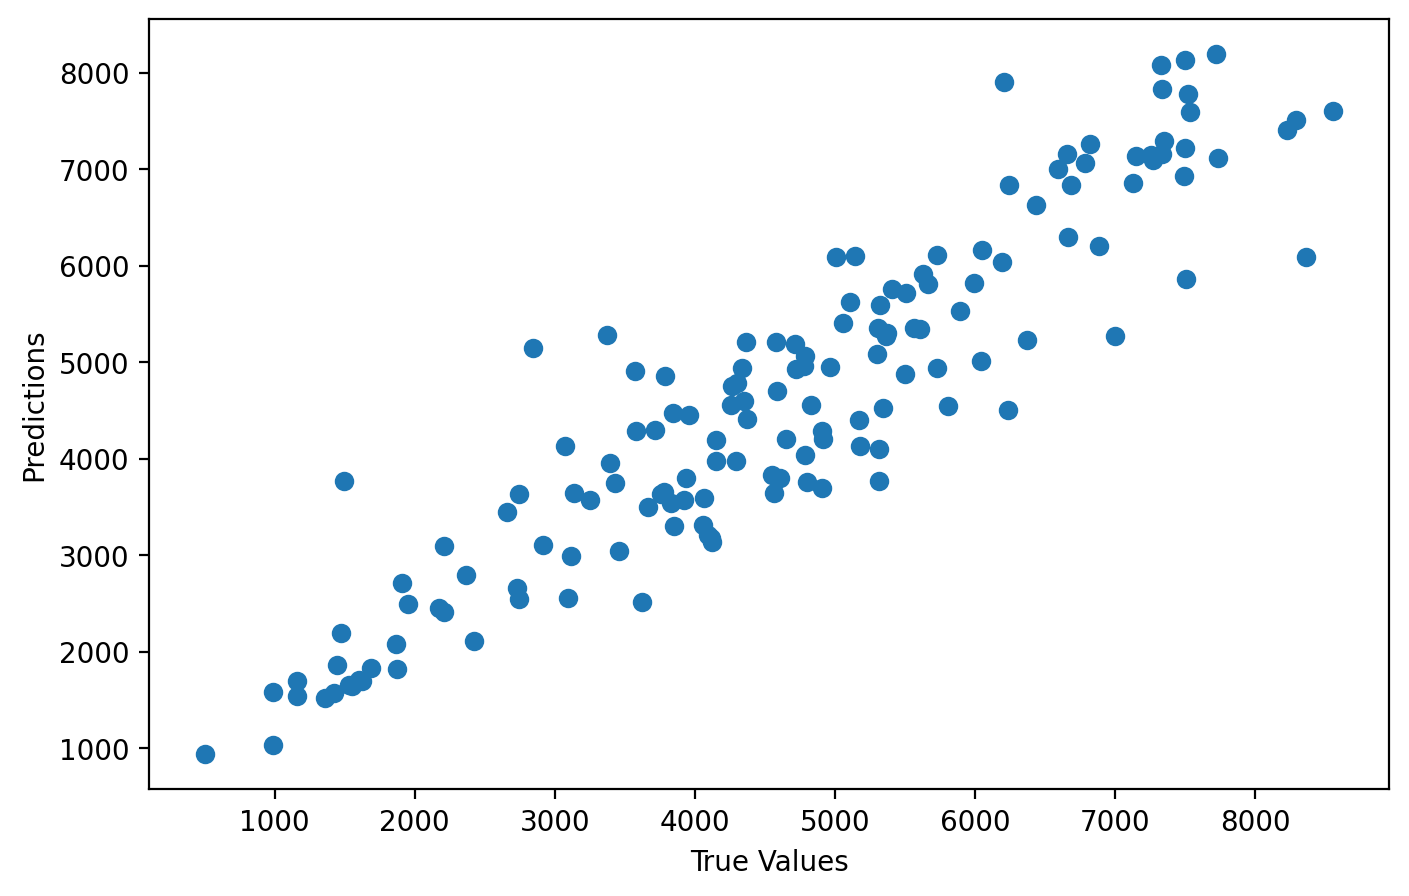

R^2 score: 0.8524234620176283
Train_loss: 581.5629272460938
Validation_loss: 743.031494140625
Test_loss: 729.2216796875


In [19]:
plot_predictions(net, test_loader, device)
y_true = np.array(y_test,dtype=object)
y_pred = net(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(net(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(net(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(net(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())


## Truth-prediction-plot

In [20]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
def plot_prediction_vs_truth(model, X_s, X, y, feature_names, num_points=None):
    """
    Function to calculate and plot prediction vs truth plot for the specified model.
    
    Args:
    model (nn.Module): Trained PyTorch model.
    X_s (np.ndarray): Scaled test set features.
    X (pd.DataFrame): Unscaled test set features.
    y (pd.Series): Test set target values.
    feature_names (list): List of feature names.
    num_points (int, optional): Number of points to use for generating plot. Default is None (use all points).
    """
    
    device = next(model.parameters()).device

    # Initialize a figure
    fig, ax = plt.subplots()

    # Define season colors
    season_colors = {'FALL': 'orange', 'WINTER': 'blue', 'SPRING': 'green', 'SUMMER': 'red'}

    # Find the index of the 'temp' feature
    temp_index = feature_names.index('temp')
    # Get the temperature values and normalize them to range [0, 1]
    tempo_values = X.loc[:, 'temp'].values
    normalized_tempo = (tempo_values - np.min(tempo_values)) / (np.max(tempo_values) - np.min(tempo_values))

    # Generate predictions using the model
    with torch.no_grad():
        model = model.eval()
        predictions = model(torch.tensor(X_s, dtype=torch.float, device=device)).cpu().numpy()

    # Draw each point, colored by season and brightness by temp
    for i in range(len(X_s)):
        season = get_season(X.iloc[i, :], feature_names)
        color = sns.light_palette(season_colors.get(season, 'grey'), as_cmap=True)(normalized_tempo[i])
        plt.scatter(y[i], predictions[i], color=color, alpha=0.5)

    # Add a 45-degree line for reference
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    # Add labels
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    
    # Add legends for seasons
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=season_colors[season], markersize=10) 
                       for season in season_colors]
    ax.legend(legend_elements, season_colors.keys(), title="Seasons")
    
    # Add colorbar for temperature
    sm = ScalarMappable(cmap=sns.light_palette("grey", as_cmap=True), norm=plt.Normalize(0,max(tempo_values)))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', label='Temperature')
    

    plt.show()

In [21]:
feature_names = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011', 'season_FALL',
                 'season_SPRING', 'season_SUMMER', 'season_WINTER', 'holiday_HOLIDAY',
                 'workingday_WORKING DAY', 'weathersit_GOOD', 'weathersit_MISTY',
                 'weathersit_RAIN/SNOW/STORM']
def get_season(instance, feature_names):
    season_prefix = 'season_'
    for name in feature_names:
        if name.startswith(season_prefix) and instance[feature_names.index(name)] == 1:
            return name[len(season_prefix):]
    return 'UNKNOWN'

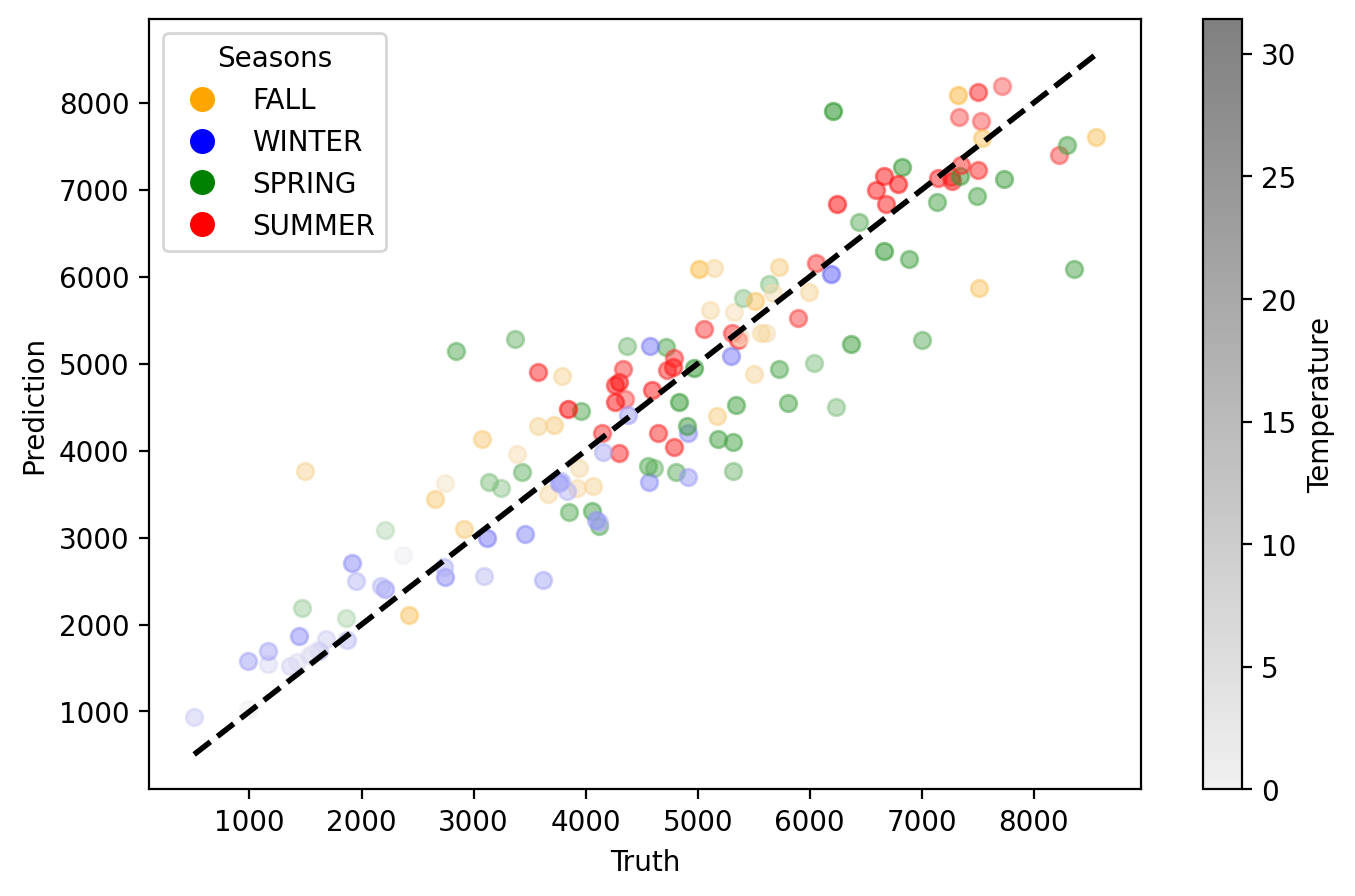

In [22]:
plot_prediction_vs_truth(net, X_test_scaled, X_test, y_test.to_numpy(), feature_names)

## ICE plots

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def ice_plot(model, X_s, X, y, feature_names, feature,title, num_points=None,loc="best"):
    """
    Function to calculate and plot Individual Conditional Expectation (ICE) plot for the specified feature.
    
    Args:
    model (nn.Module): Trained PyTorch model.
    X_s (np.ndarray): Scaled test set features.
    X (pd.DataFrame): Unscaled test set features.
    y (pd.Series): Test set target values.
    feature_index (int): Index of the feature for which ICE plot is to be calculated.
    feature_names (list): List of feature names.
    feature (str): Name of the feature for which ICE plot is to be calculated.
    num_points (int, optional): Number of points to use for generating ICE plot. Default is None (use all unique values).
    """
    
    feature_index=feature_names.index(feature)
    
    device = next(model.parameters()).device

    # Extract the unique feature values from the unscaled data
    feature_values = X.loc[:, feature].sort_values()
    feature_values_s = np.sort(X_s[:, feature_index])
    

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values[idx]
        feature_values_s = feature_values_s[idx]

    # Initialize a figure
    plt.figure()
    
    XXX = X_s.copy()
    predictions_all = []
    # Define season colors
    season_colors = {'FALL': 'orange', 'SPRING': 'green', 'SUMMER': 'red', 'WINTER': 'blue'}

    
    # Loop through instances in the test set
    for instance,i in zip(XXX,X.values):
        # Create an array to store predictions for this instance
        predictions = []
        original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)).item()

        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val

            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                prediction = model(instance_tensor).item()
            predictions.append(prediction)

        predictions_all.append(predictions)
        # Get the season for the current instance
        season = get_season(i, feature_names)
        
        # Plot the ICE curve for this instance in grey with transparency
        plt.plot(feature_values, predictions, color=season_colors.get(season, 'grey'), alpha=0.5)
        
          # Plot the marker for the original value
        original_val = i[feature_index]
        plt.scatter(original_val, original_prediction, marker='o', color=season_colors.get(season, 'grey'), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)
    print(len(predictions_all))

    # Plot the mean ICE curve in red and thicker
    plt.plot(feature_values, mean_predictions, color='black', linewidth=4)

    # Label the plot
    plt.xlabel(feature_names[feature_index])
    plt.ylabel('Predictions')
    plt.title(title)
    
     # Create proxy artists for legend
    legend_elements = [Line2D([0], [0], color=season_colors[season], lw=2, label=season) for season in season_colors]

    # Add the legend with the proxy artists
    plt.legend(handles=legend_elements, title='Seasons', loc=loc)

    # Show the plot
    plt.show()


147


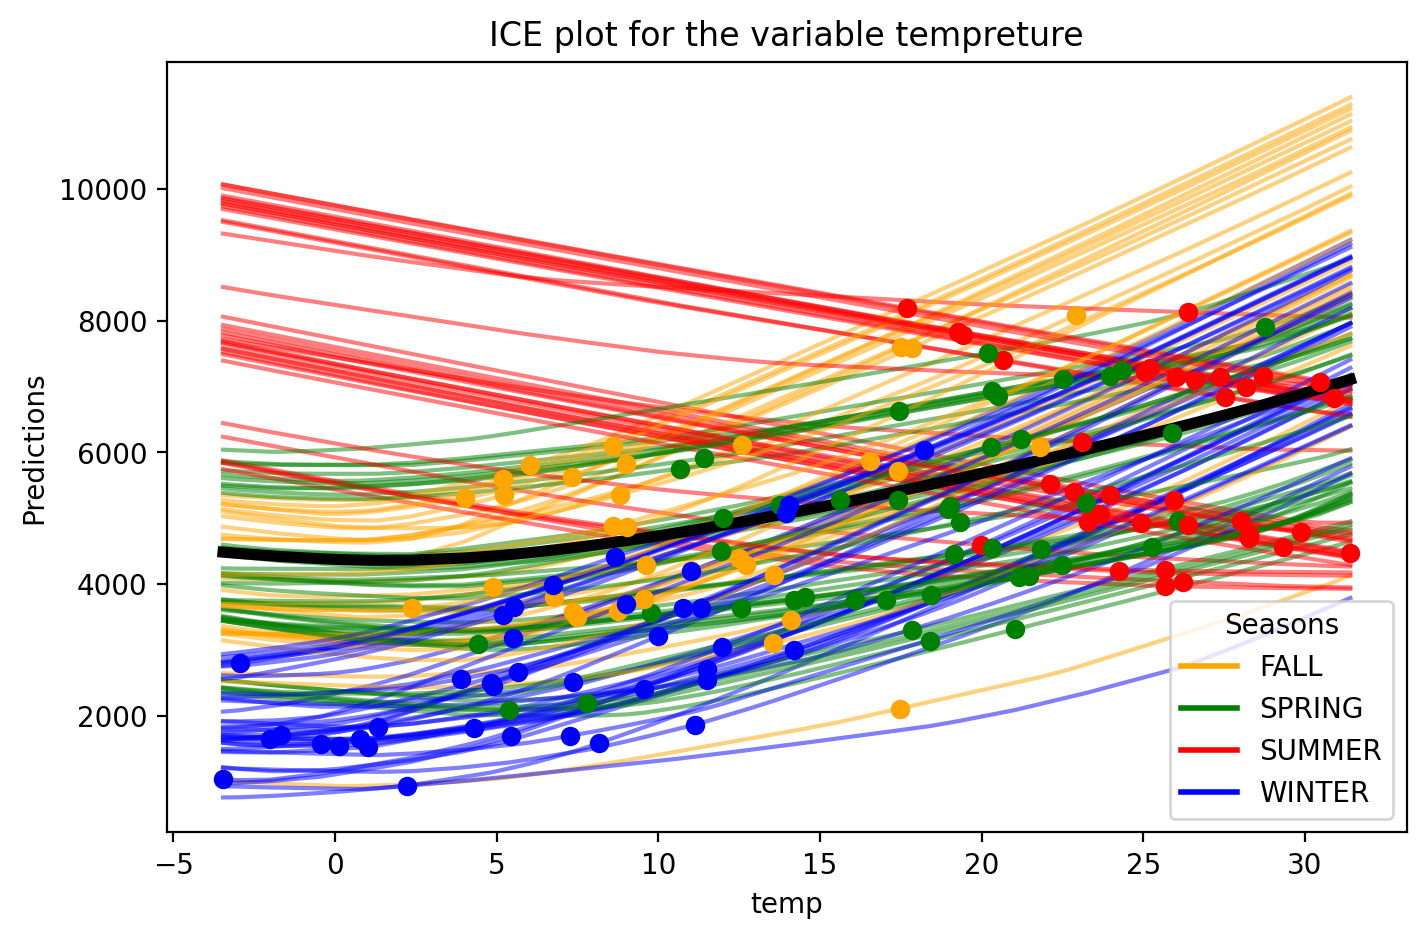

In [24]:
ice_plot(net, X_test_scaled,X_test, y_test, feature_names,'temp',"ICE plot for the variable tempreture")



147


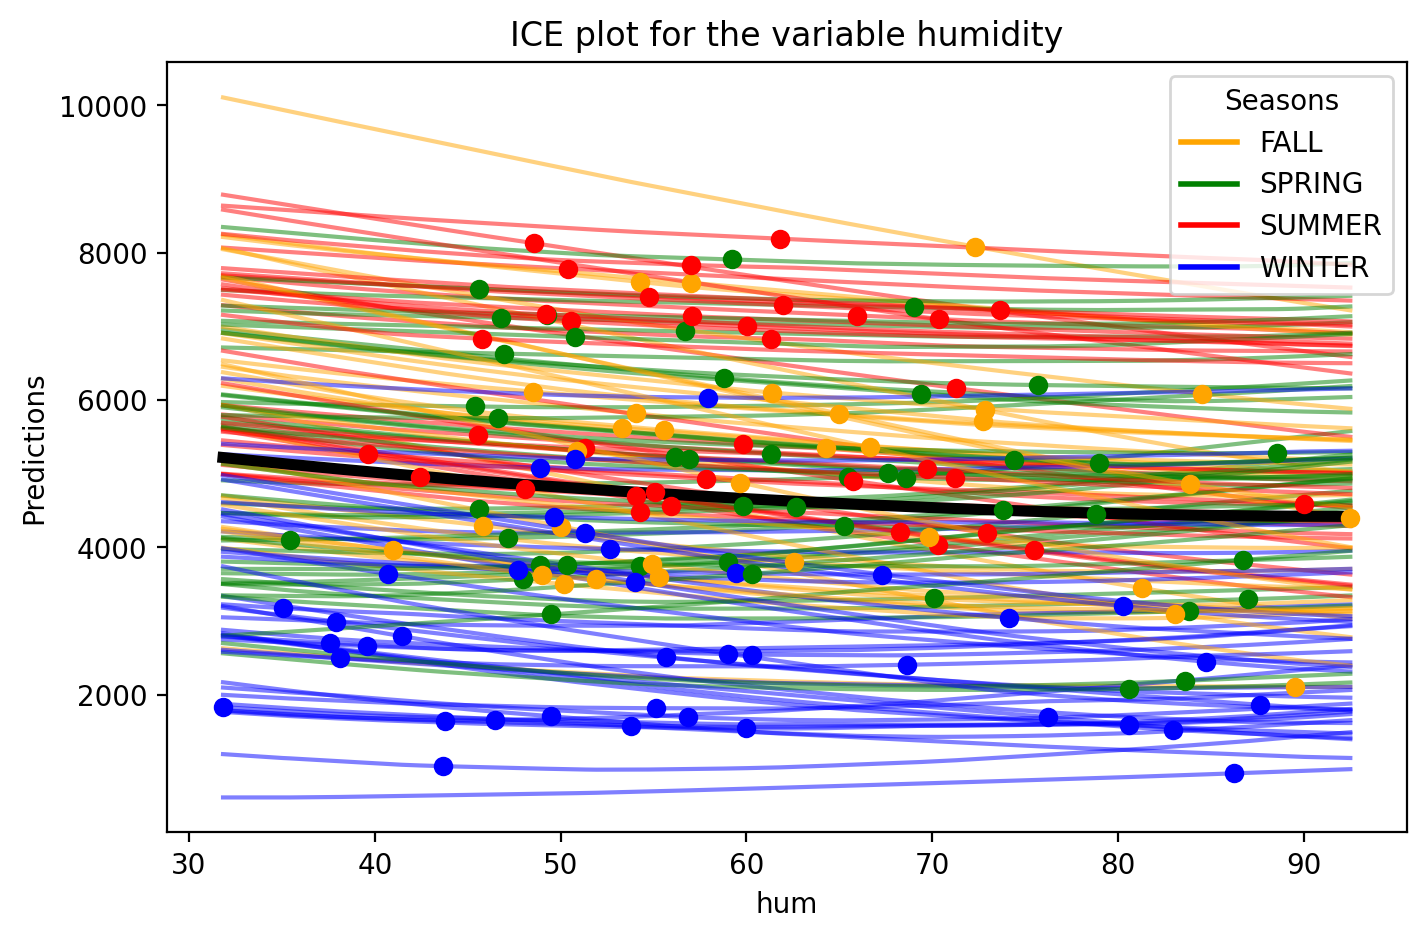

In [25]:
ice_plot(net, X_test_scaled,X_test, y_test, feature_names,'hum',"ICE plot for the variable humidity")


147


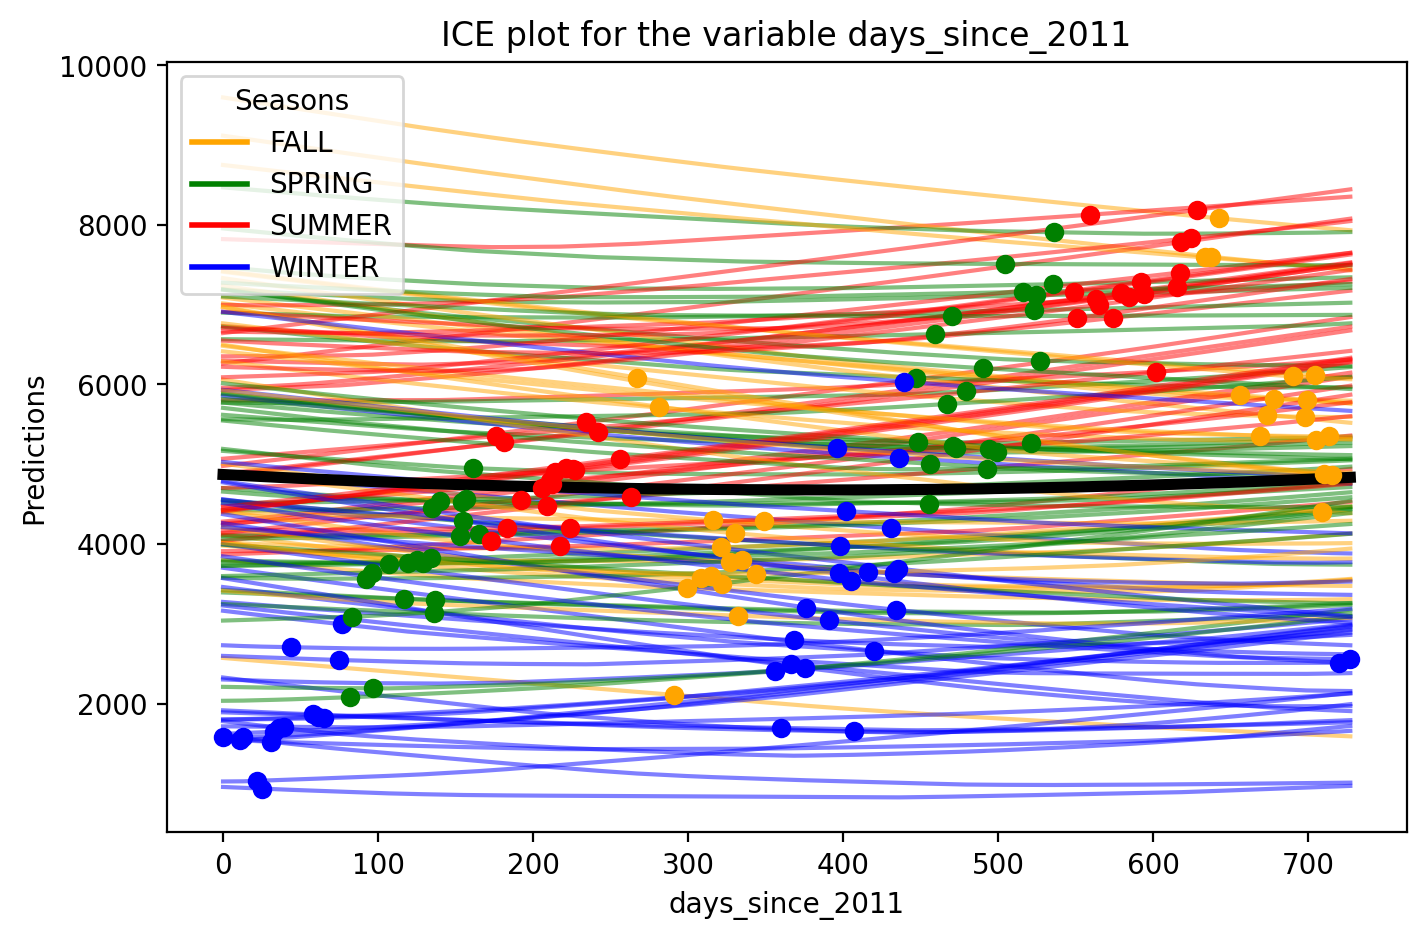

In [26]:
ice_plot(net, X_test_scaled,X_test, y_test, feature_names,'days_since_2011',"ICE plot for the variable days_since_2011",loc="upper left")


147


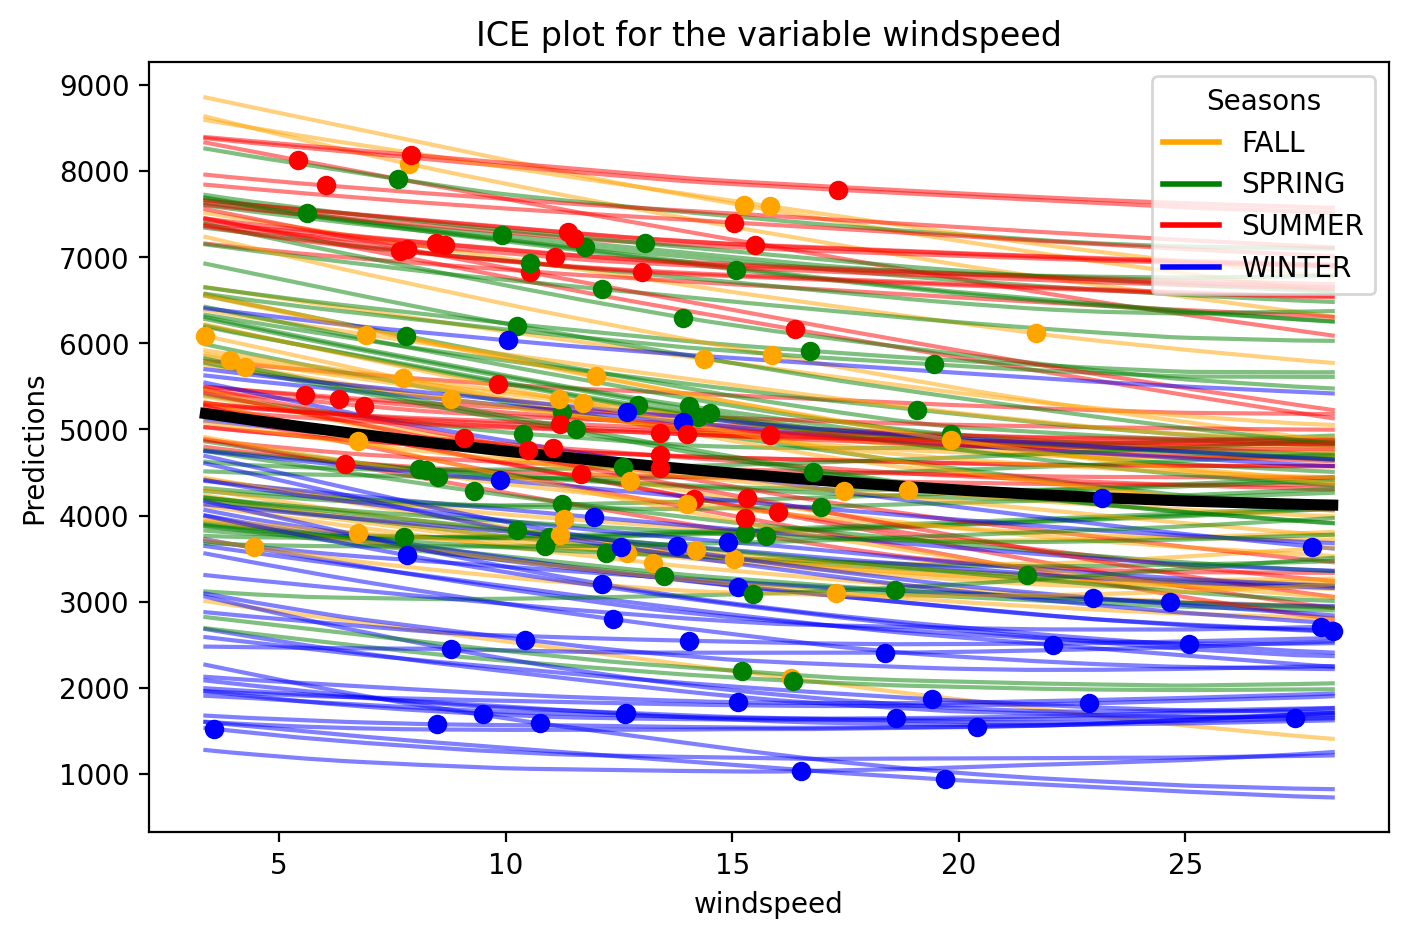

In [27]:
ice_plot(net, X_test_scaled,X_test, y_test, feature_names,'windspeed',"ICE plot for the variable windspeed")


147


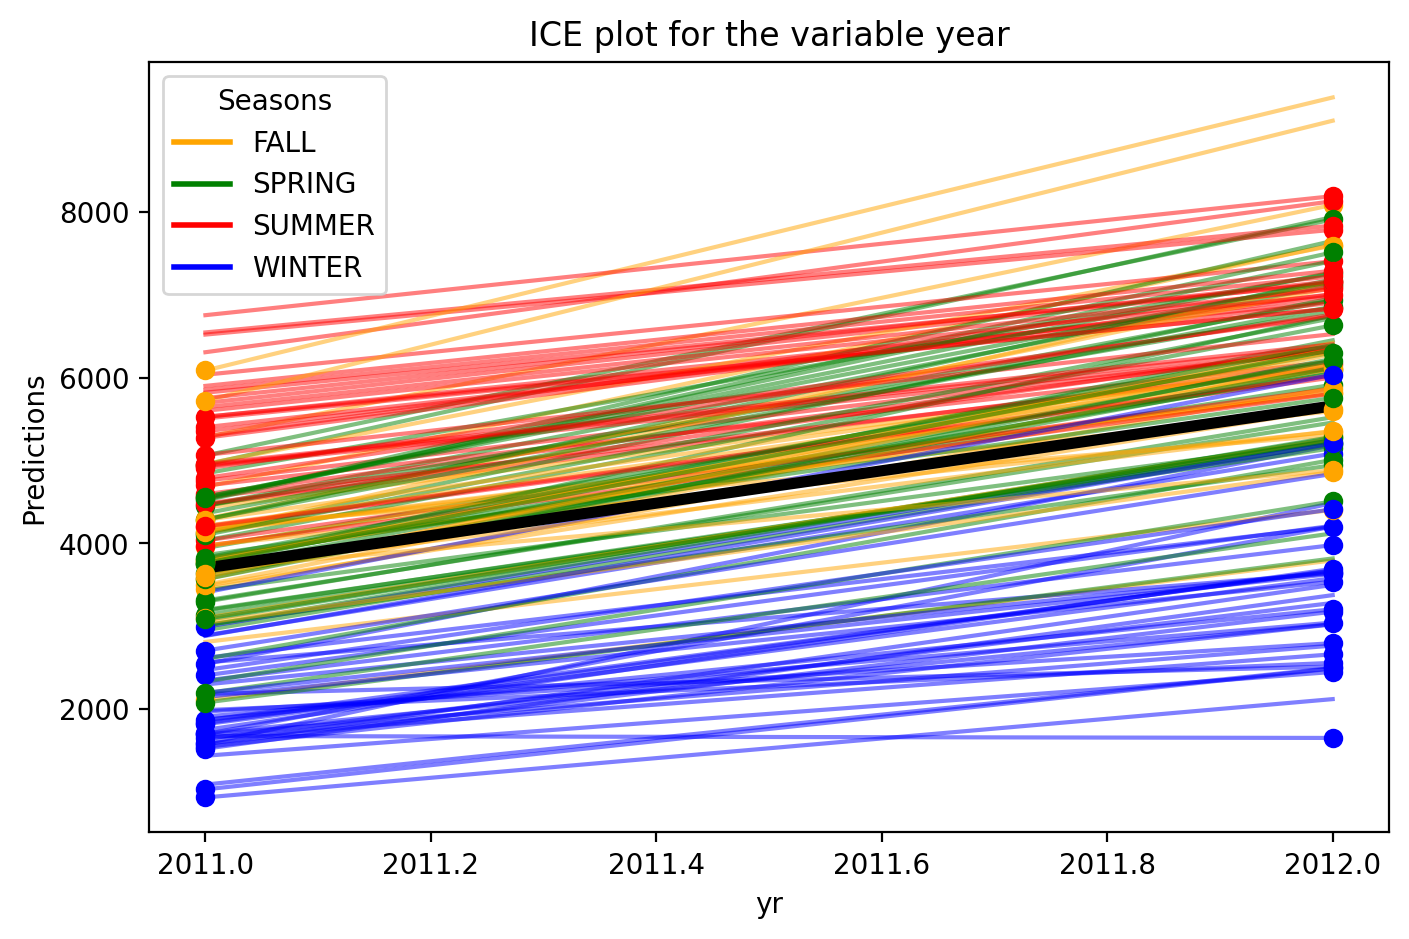

In [28]:
ice_plot(net, X_test_scaled,X_test, y_test, feature_names,'yr',"ICE plot for the variable year")


## KernelSHAP feature importance

In [29]:
from captum.attr import KernelShap

In [30]:
baseline_unscaled = X_test.mean(axis=0)

In [31]:
baseline_unscaled

yr                            2011.510204
temp                            15.322261
hum                             60.256324
windspeed                       13.208245
days_since_2011                361.142857
season_FALL                      0.210884
season_SPRING                    0.292517
season_SUMMER                    0.238095
season_WINTER                    0.258503
holiday_HOLIDAY                  0.020408
workingday_WORKING DAY           0.700680
weathersit_GOOD                  0.639456
weathersit_MISTY                 0.346939
weathersit_RAIN/SNOW/STORM       0.013605
dtype: float64

In [32]:
y_test_series = y_test.iloc[:, 0]
device=torch.device('cpu')
worst_instance = torch.tensor(X_test_scaled[y_test_series.argmin()]).unsqueeze(0).float().to(device)
best_instance = torch.tensor(X_test_scaled[y_test_series.argmax()]).unsqueeze(0).float().to(device)

baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)
#baseline_value=net(torch.Tensor(X_test_scaled).to(device)).mean().item()
print(net(best_instance))
print(net(worst_instance))
#print(net(torch.Tensor(X_test_scaled).to(device)).mean())
print(net(baseline))


tensor([[7602.1064]], grad_fn=<AddmmBackward0>)
tensor([[933.2081]], grad_fn=<AddmmBackward0>)
tensor([[1655.7354]], grad_fn=<AddmmBackward0>)


In [33]:
# Instantiate KernelShap
ks = KernelShap(net)

In [34]:
worst_shap_values = ks.attribute(worst_instance, baseline,n_samples=30000)
best_shap_values = ks.attribute(best_instance, baseline,n_samples=30000)
baseline_shap_values=ks.attribute(baseline, baseline,n_samples=30000)

In [35]:
worst_shap_np = worst_shap_values.cpu().detach().numpy()
best_shap_np = best_shap_values.cpu().detach().numpy()

In [36]:
best_shap_np

array([[1621.0931 ,  365.81714,  128.12262, -149.92416, -244.12973,
        1690.598  ,  348.74362,  639.4274 ,  471.8459 ,   83.34668,
         186.71425,  469.53326,  247.25494,   87.0323 ]], dtype=float32)

In [37]:
import shap
def shap_vis(values,baseline_shap_values,data):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=feature_names)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

[1621.0931   365.81714  128.12262 -149.92416 -244.12973 1690.598
  348.74362  639.4274   471.8459    83.34668  186.71425  469.53326
  247.25494   87.0323 ]
1655.7353515625
yr                            2012.000000
temp                            17.497500
hum                             54.291700
windspeed                       15.249468
days_since_2011                637.000000
season_FALL                      1.000000
season_SPRING                    0.000000
season_SUMMER                    0.000000
season_WINTER                    0.000000
holiday_HOLIDAY                  0.000000
workingday_WORKING DAY           0.000000
weathersit_GOOD                  1.000000
weathersit_MISTY                 0.000000
weathersit_RAIN/SNOW/STORM       0.000000
Name: 637, dtype: float64


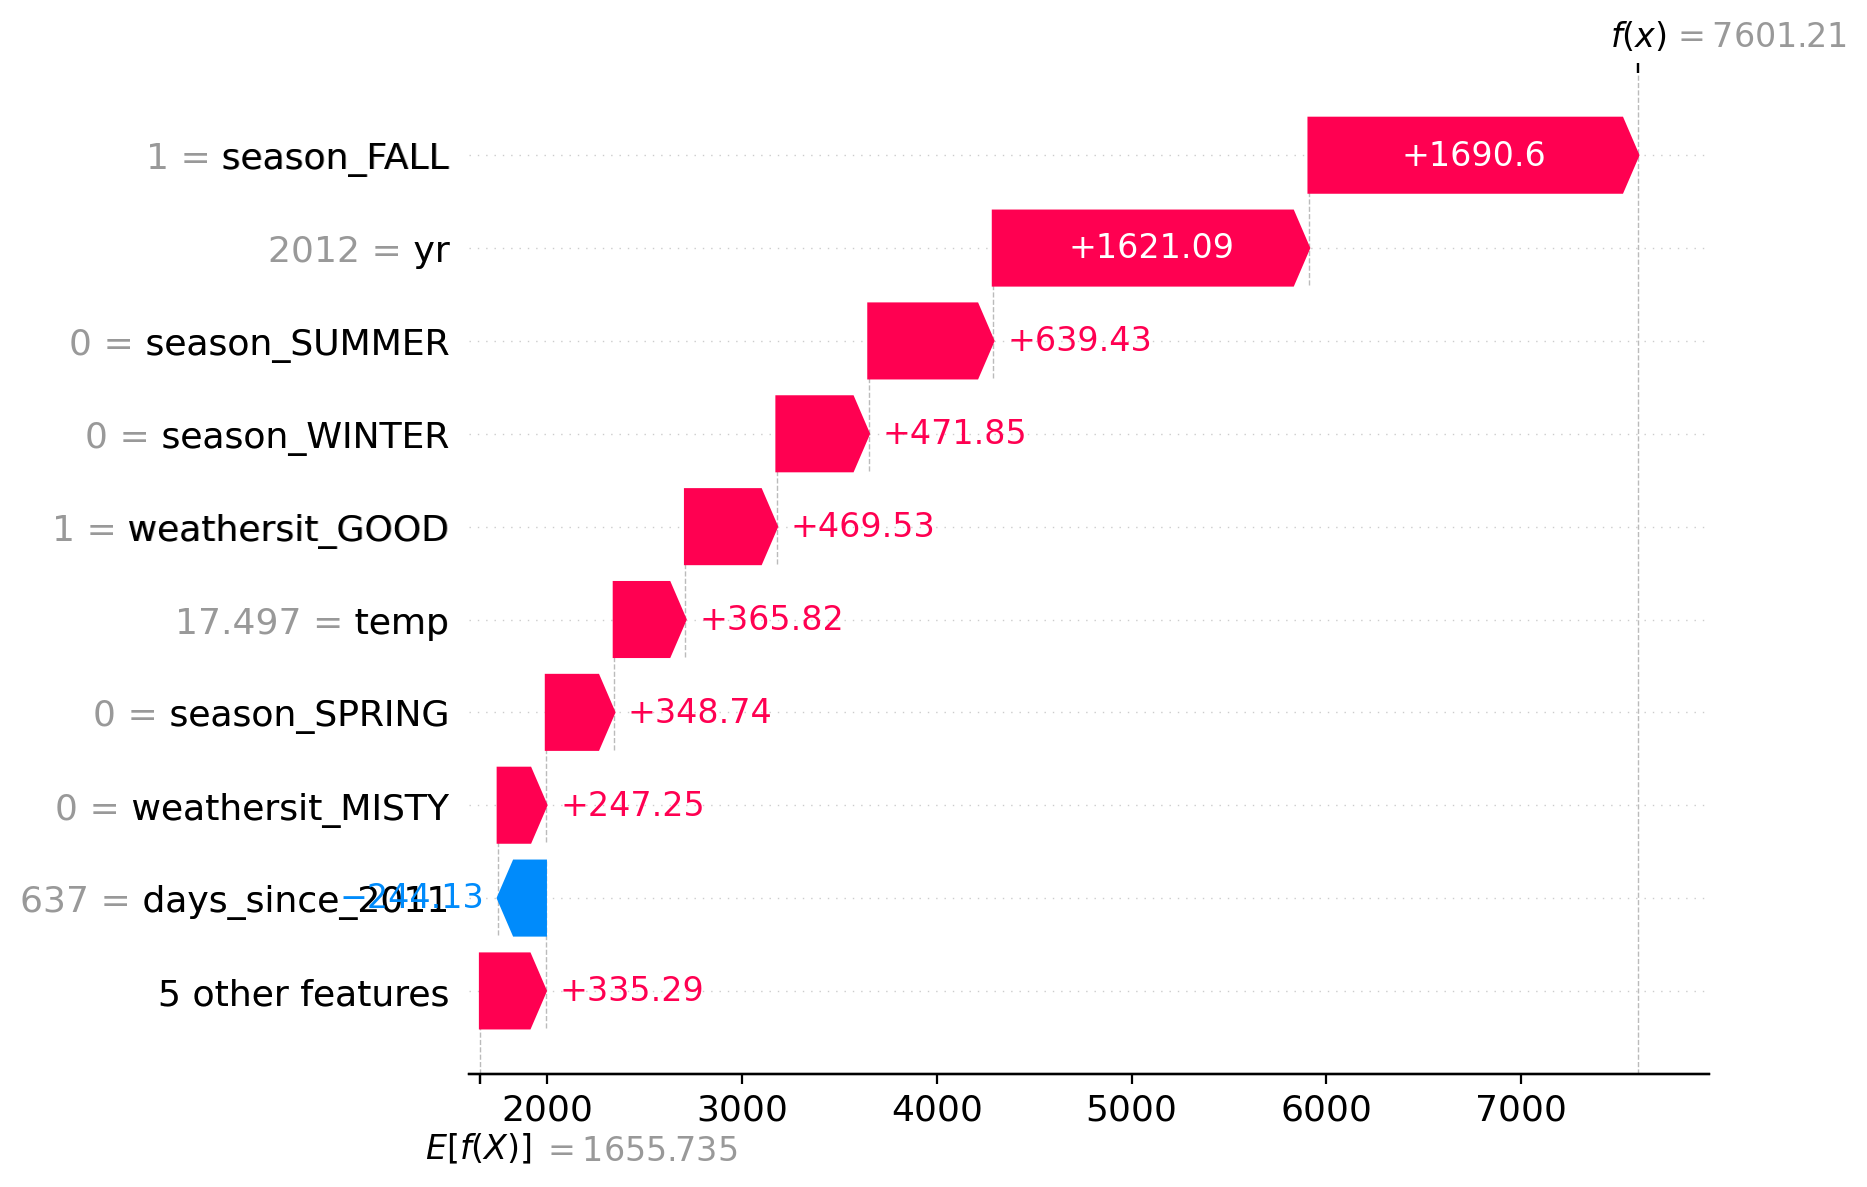

In [38]:
shap_vis(best_shap_np[0],net(baseline).item(),X_test.iloc[y_test_series.argmax()])

[-476.59323   -341.11682     64.890526  -156.86076    120.37107
   -9.883041   195.00522    186.11743      3.5597763   44.927986
   85.892525  -190.82132    170.1683    -420.2016   ]
1655.7353515625
yr                            2011.00000
temp                             2.22250
hum                             86.25000
windspeed                       19.68795
days_since_2011                 25.00000
season_FALL                      0.00000
season_SPRING                    0.00000
season_SUMMER                    0.00000
season_WINTER                    1.00000
holiday_HOLIDAY                  0.00000
workingday_WORKING DAY           1.00000
weathersit_GOOD                  0.00000
weathersit_MISTY                 0.00000
weathersit_RAIN/SNOW/STORM       1.00000
Name: 25, dtype: float64


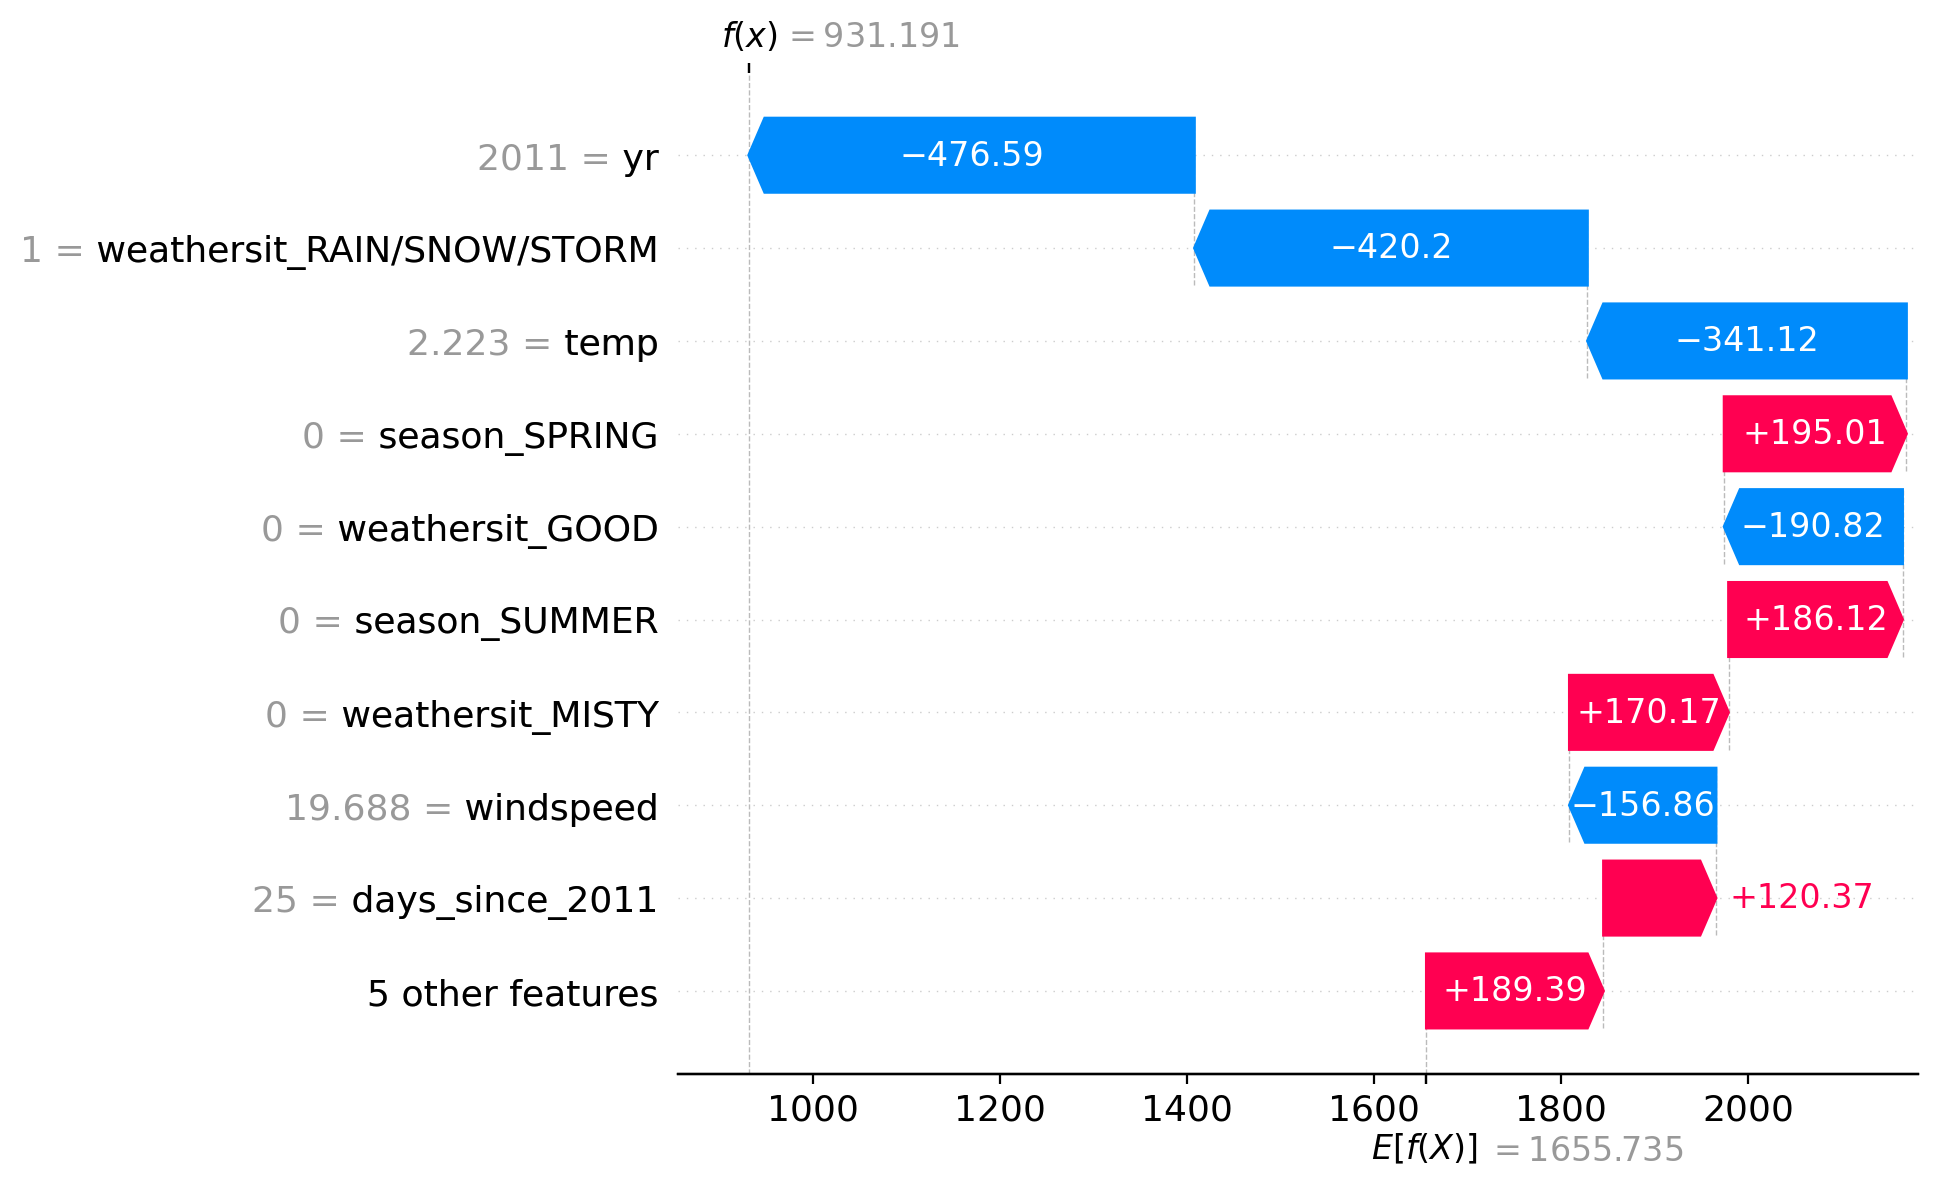

In [39]:
shap_vis(worst_shap_np[0],net(baseline).item(),X_test.iloc[y_test_series.argmin()])

In [40]:
summer=X_test[X_test['season_SUMMER'] == 1].sample(1)

In [41]:
summer

yr       temp      hum  windspeed  days_since_2011  season_FALL  \
221  2011  28.033349  42.4167  13.417286              221            0   

     season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
221              0              1              0                0   

     workingday_WORKING DAY  weathersit_GOOD  weathersit_MISTY  \
221                       1                1                 0   

     weathersit_RAIN/SNOW/STORM  
221                           0

In [42]:
summer_sample = torch.tensor(scaler.transform(summer.values)).float().to(device)


X does not have valid feature names, but StandardScaler was fitted with feature names


In [43]:
summer_sample

tensor([[-0.9809,  1.5007, -1.4404,  0.1346, -0.6617, -0.5749, -0.5551,  1.6723,
         -0.5815, -0.1692,  0.6947,  0.7706, -0.7117, -0.1944]])

In [44]:
summer_mean = torch.tensor(scaler.transform(X_test[X_test['season_SUMMER'] == 1].mean().values.reshape(1, -1))).float().to(device)


X does not have valid feature names, but StandardScaler was fitted with feature names


In [45]:
summer_mean

tensor([[-0.0665,  1.2076, -0.2564, -0.2859,  0.1085, -0.5749, -0.5551,  1.6723,
         -0.5815, -0.1692,  0.1459,  0.2388, -0.1673, -0.1944]])

In [46]:
print("SUMMER")
print(X_test[X_test['season_SUMMER'] == 1].mean())

SUMMER
yr                            2011.457143
temp                            25.504284
hum                             59.641657
windspeed                       11.234821
days_since_2011                385.171429
season_FALL                      0.000000
season_SPRING                    0.000000
season_SUMMER                    1.000000
season_WINTER                    0.000000
holiday_HOLIDAY                  0.000000
workingday_WORKING DAY           0.742857
weathersit_GOOD                  0.742857
weathersit_MISTY                 0.257143
weathersit_RAIN/SNOW/STORM       0.000000
dtype: float64


In [47]:
base_value_summer=net(summer_mean)
print(net(summer_sample))
print(net(summer_mean))
base_value_summer

tensor([[4955.8296]], grad_fn=<AddmmBackward0>)
tensor([[5319.9771]], grad_fn=<AddmmBackward0>)


tensor([[5319.9771]], grad_fn=<AddmmBackward0>)

In [48]:
ks = KernelShap(net)

In [49]:
summer_shap_values = ks.attribute(summer_sample, summer_mean,n_samples=30000)

In [50]:
summer_shap_values

tensor([[-5.5497e+02, -2.0723e+02,  3.2851e+02, -7.9211e+01, -3.9147e+02,
          8.2561e-02,  7.4036e-01, -5.8904e-01,  7.1980e-02, -4.0022e-01,
          1.2305e+02,  2.3726e+02,  1.7985e+02,  1.0535e-01]])

[-5.5496600e+02 -2.0723201e+02  3.2850708e+02 -7.9211487e+01
 -3.9147363e+02  8.2561493e-02  7.4035645e-01 -5.8903503e-01
  7.1979523e-02 -4.0022278e-01  1.2304509e+02  2.3726103e+02
  1.7985172e+02  1.0535431e-01]
5319.97705078125
[2.0110000e+03 2.8033349e+01 4.2416700e+01 1.3417286e+01 2.2100000e+02
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]


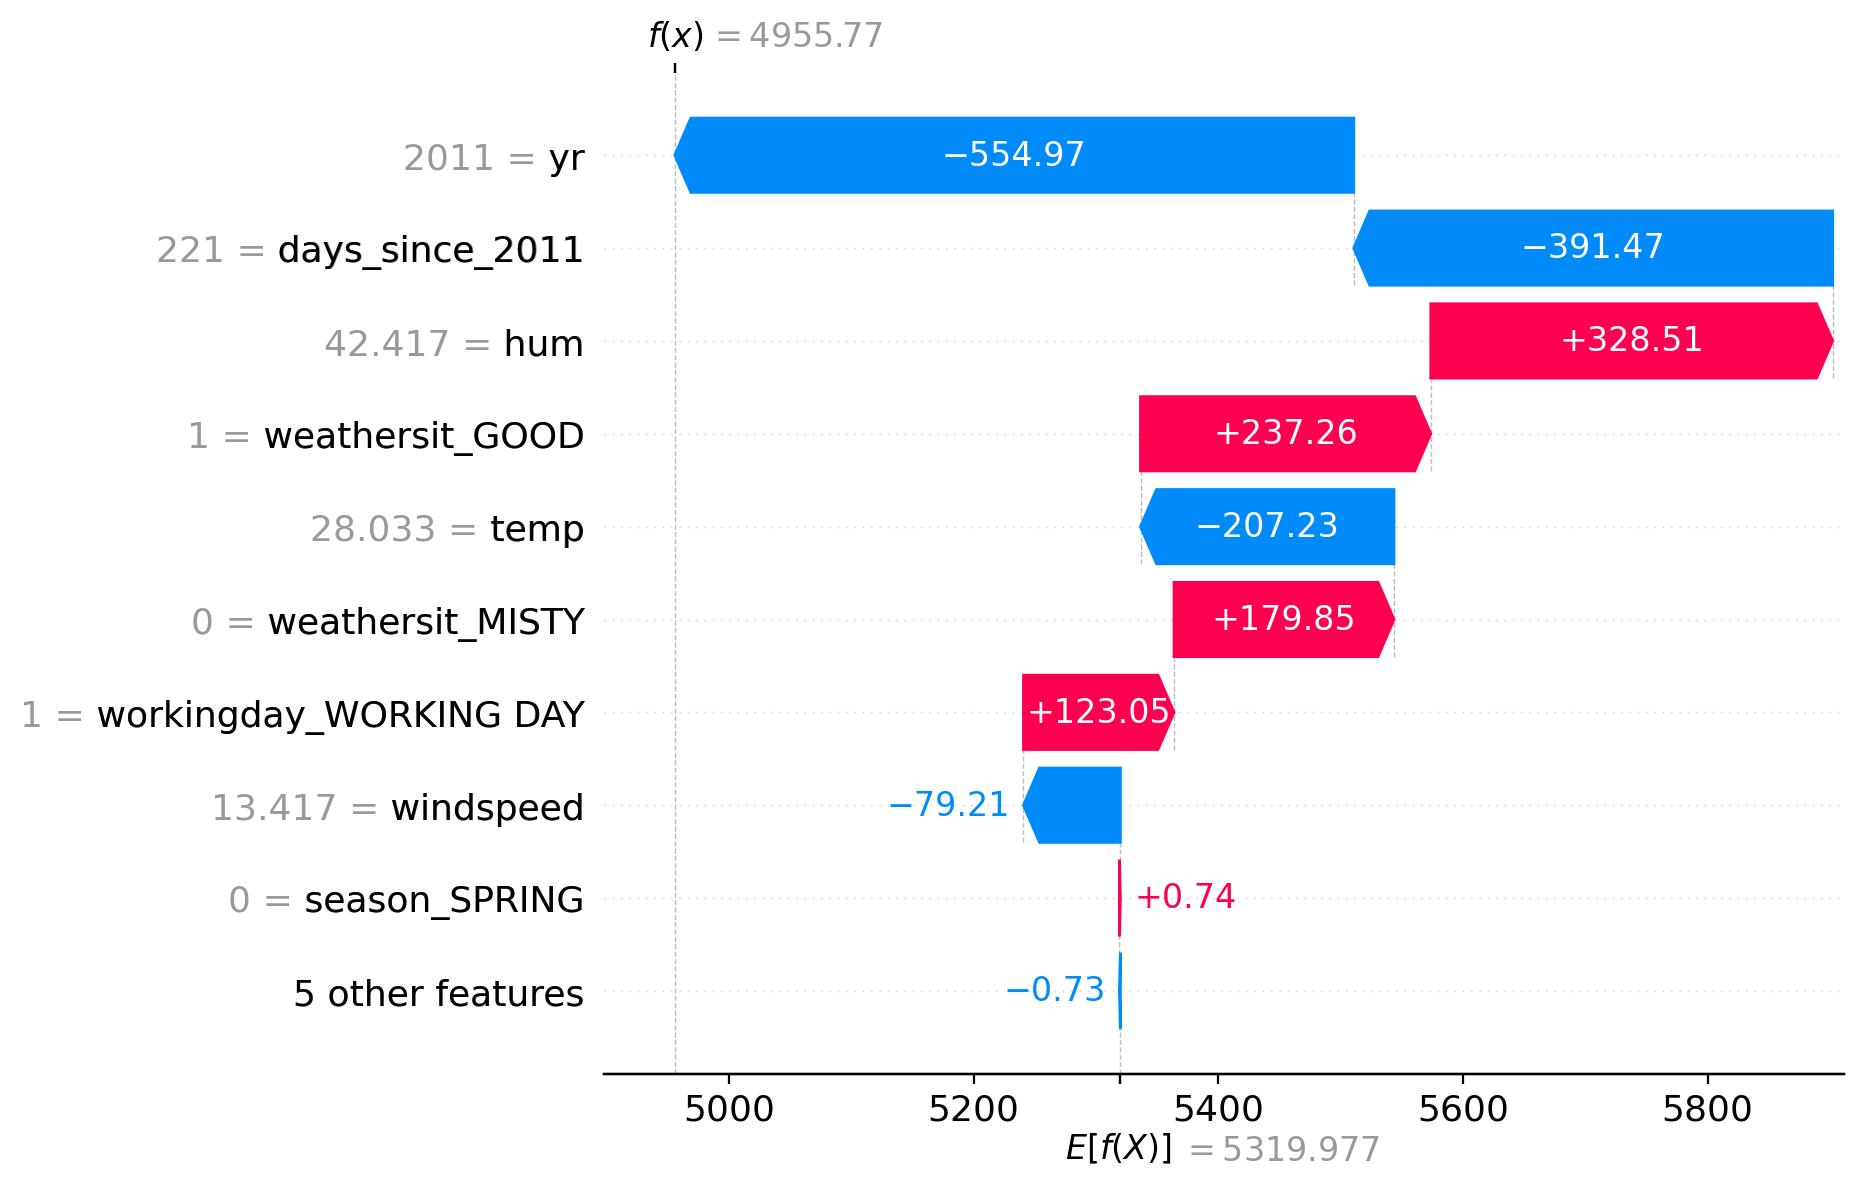

In [51]:
shap_vis(summer_shap_values.cpu().detach().numpy()[0],base_value_summer.item(),summer.to_numpy()[0])

## Feature importance

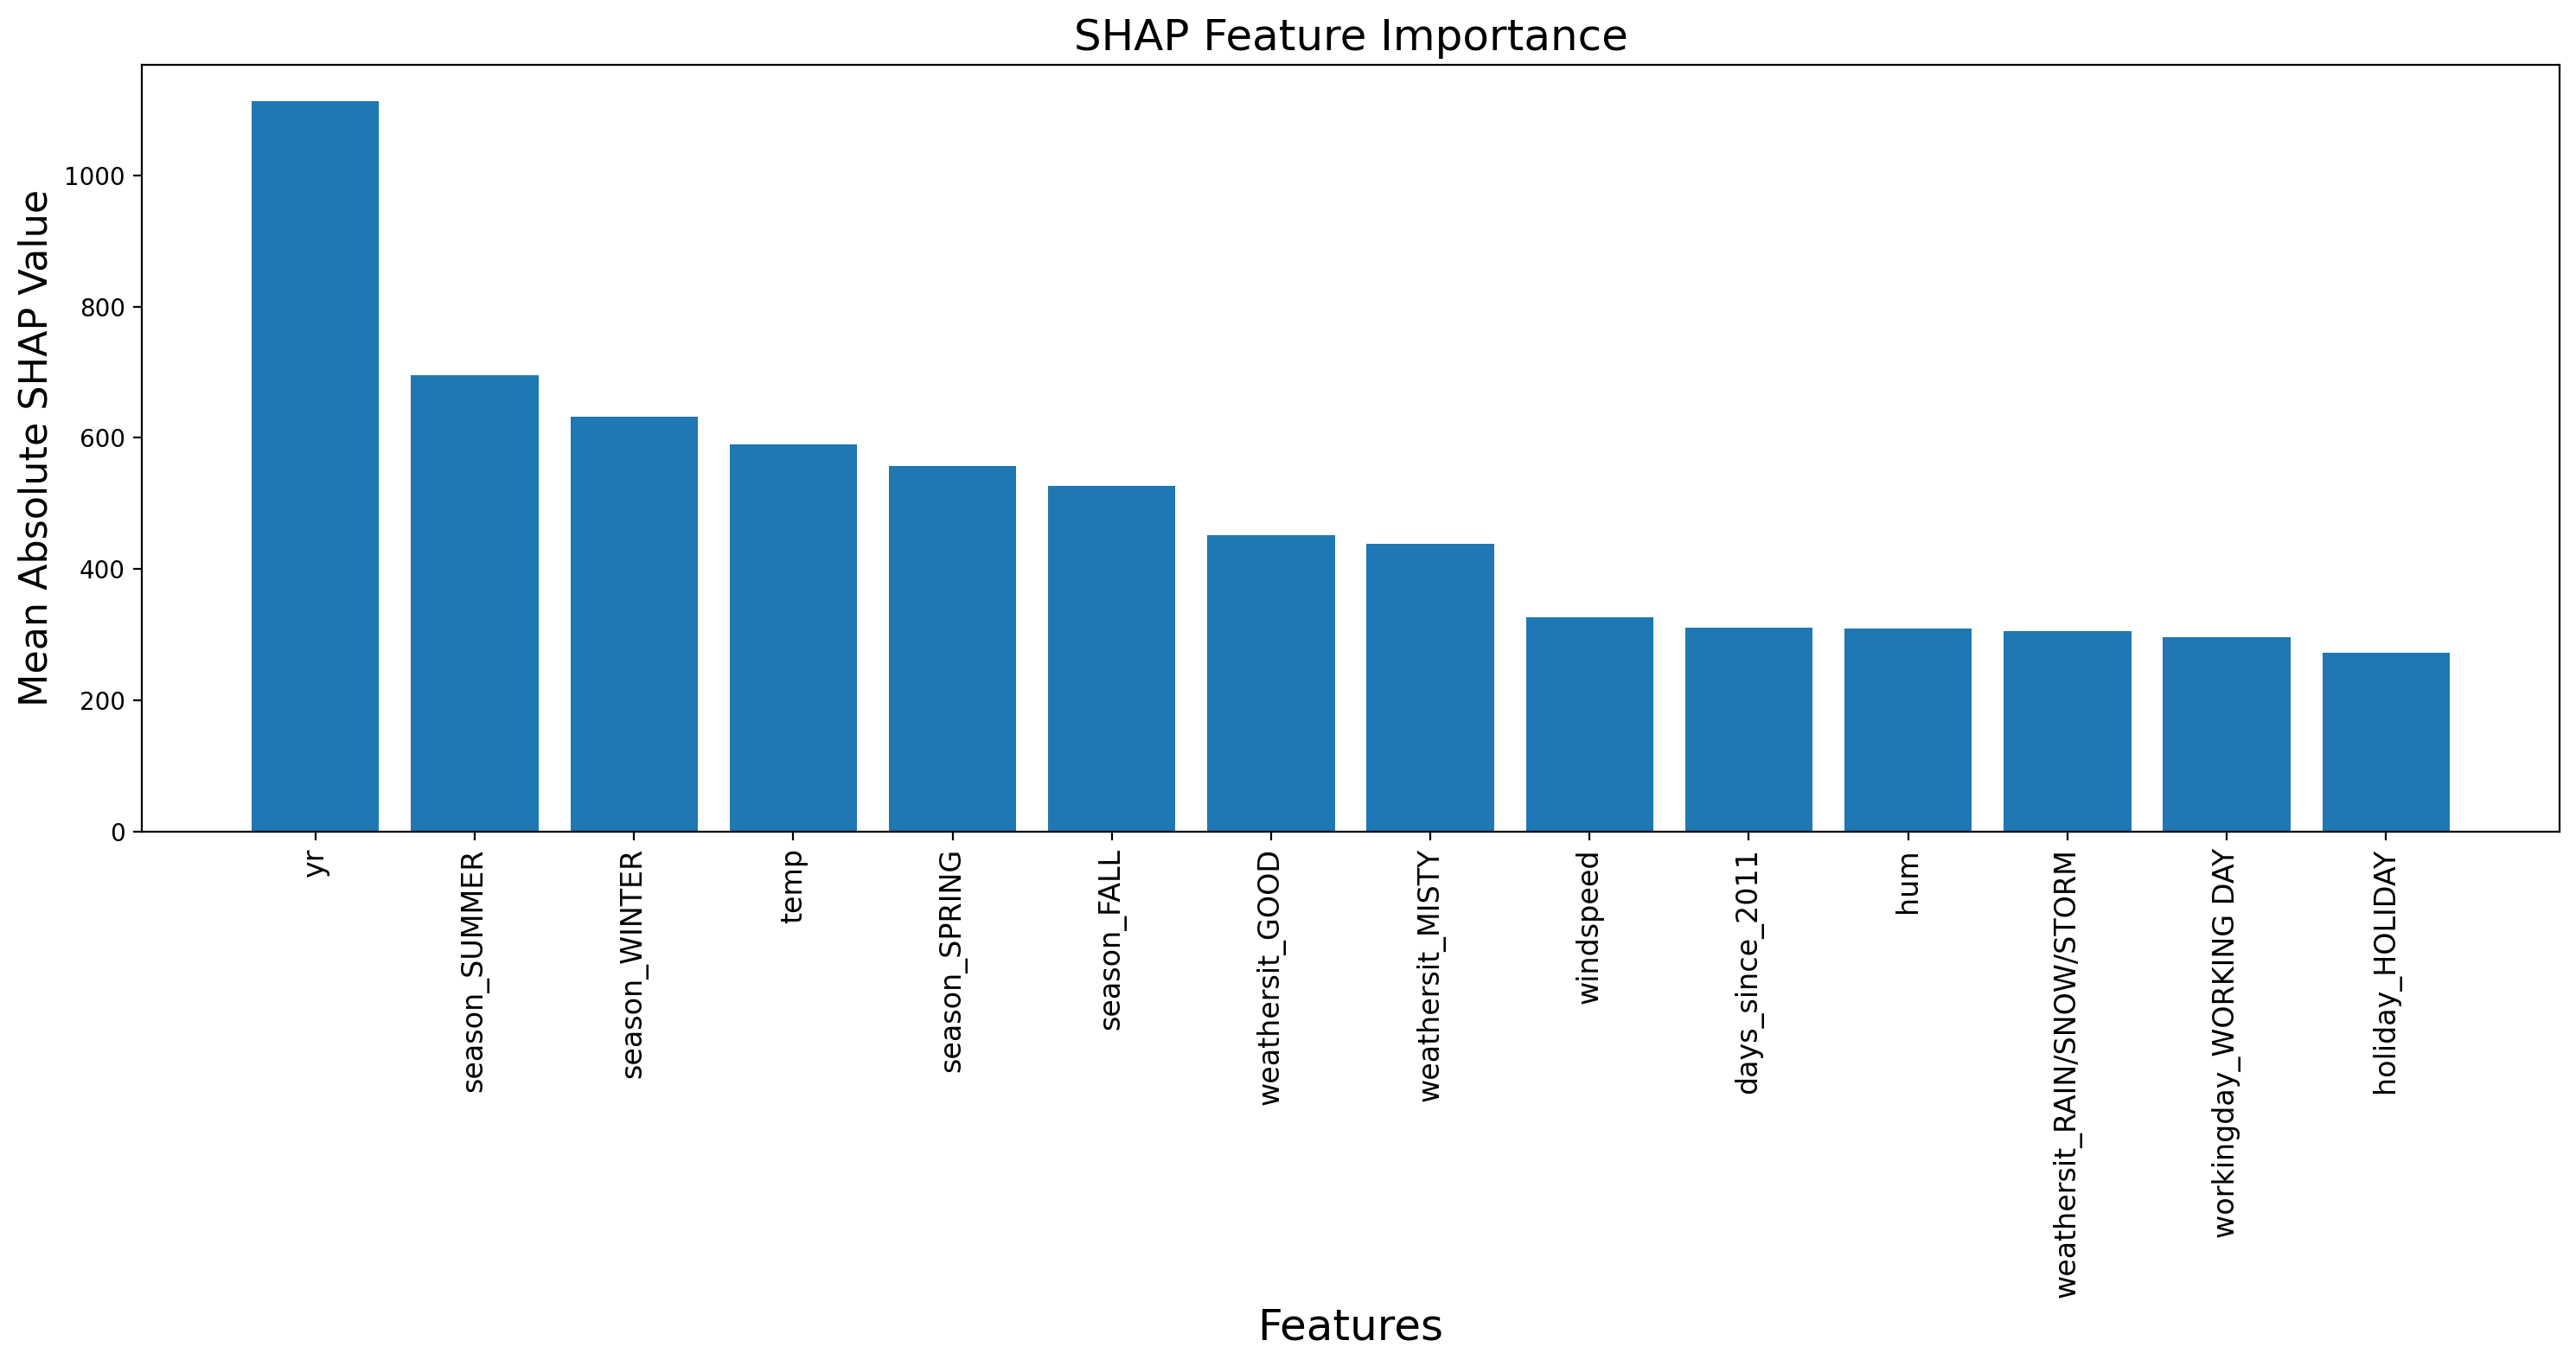

In [52]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
sk = KernelShap(net)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled)  
# Attribute SHAP values
global_shap_values = []

for instance in X_test_t:
    shap_values = sk.attribute(instance.unsqueeze(0).float().to(device), baseline)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


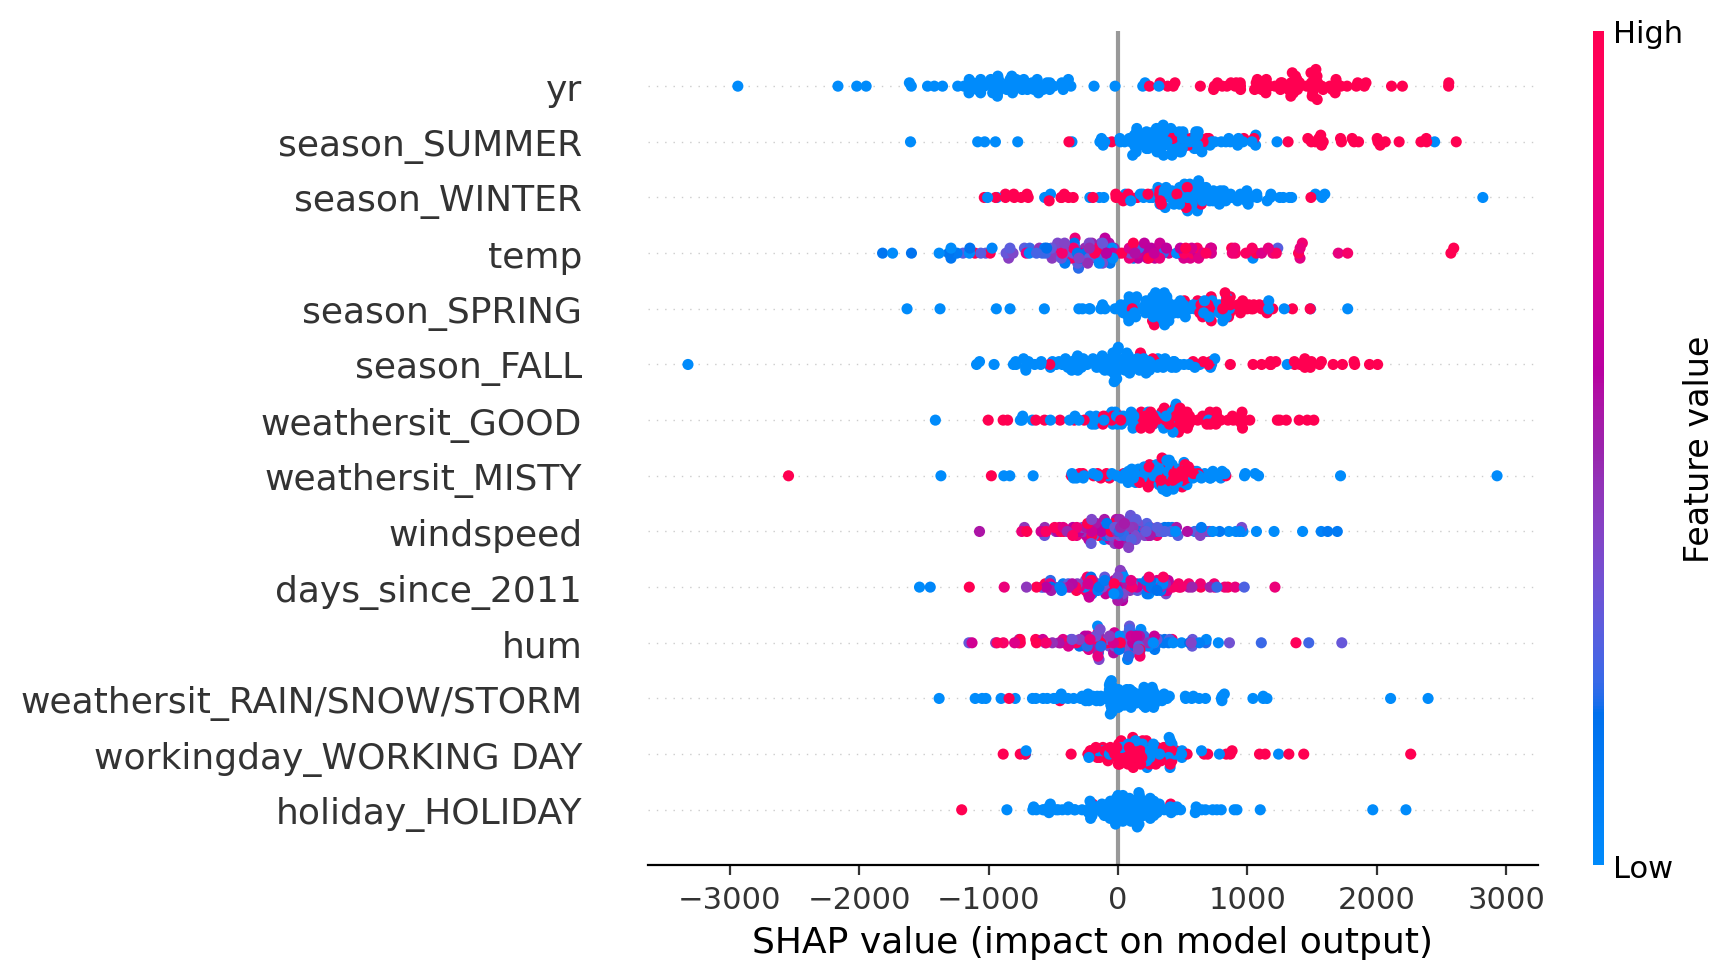

In [53]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled, feature_names=X_test.columns,plot_size=(9,5))
